# Desafio Parte 2 - Ingestão de dados do Twitter e/ou TMBD

## Instruções

Neste etapa do desafio, nos iremos capturar tweets em tempo real com Python por meio da lib tweepy e/ou dados existentes na API do **TMDB** via AWS Lambda. Os dados coletados devem ser persistidos em Amazon S3, camada de RAW Zone, mantendo o formato da origem (JSON) e agrupando-os em arquivos com, no máximo, 100 tweets cada.

Esta atividade corresponde a parte do desafio final. Não esperamos que você registre resposta neste espaço. **Contudo, deves adicionar o código-fonte produzido ao seu repositório no Github. Lembre-se de remover suas credenciais de acesso antes de efetuar commit.**

Em sua conta AWS, no serviço **AWS Lambda**, realize as seguintes atividades:

## Etapa 1 

Criar nova camada (layer) no AWS Lambda para as libs necessárias à ingestão de dados (por exemplo,  tweepy, se você utilizar o Tweeter)

### Print de execução

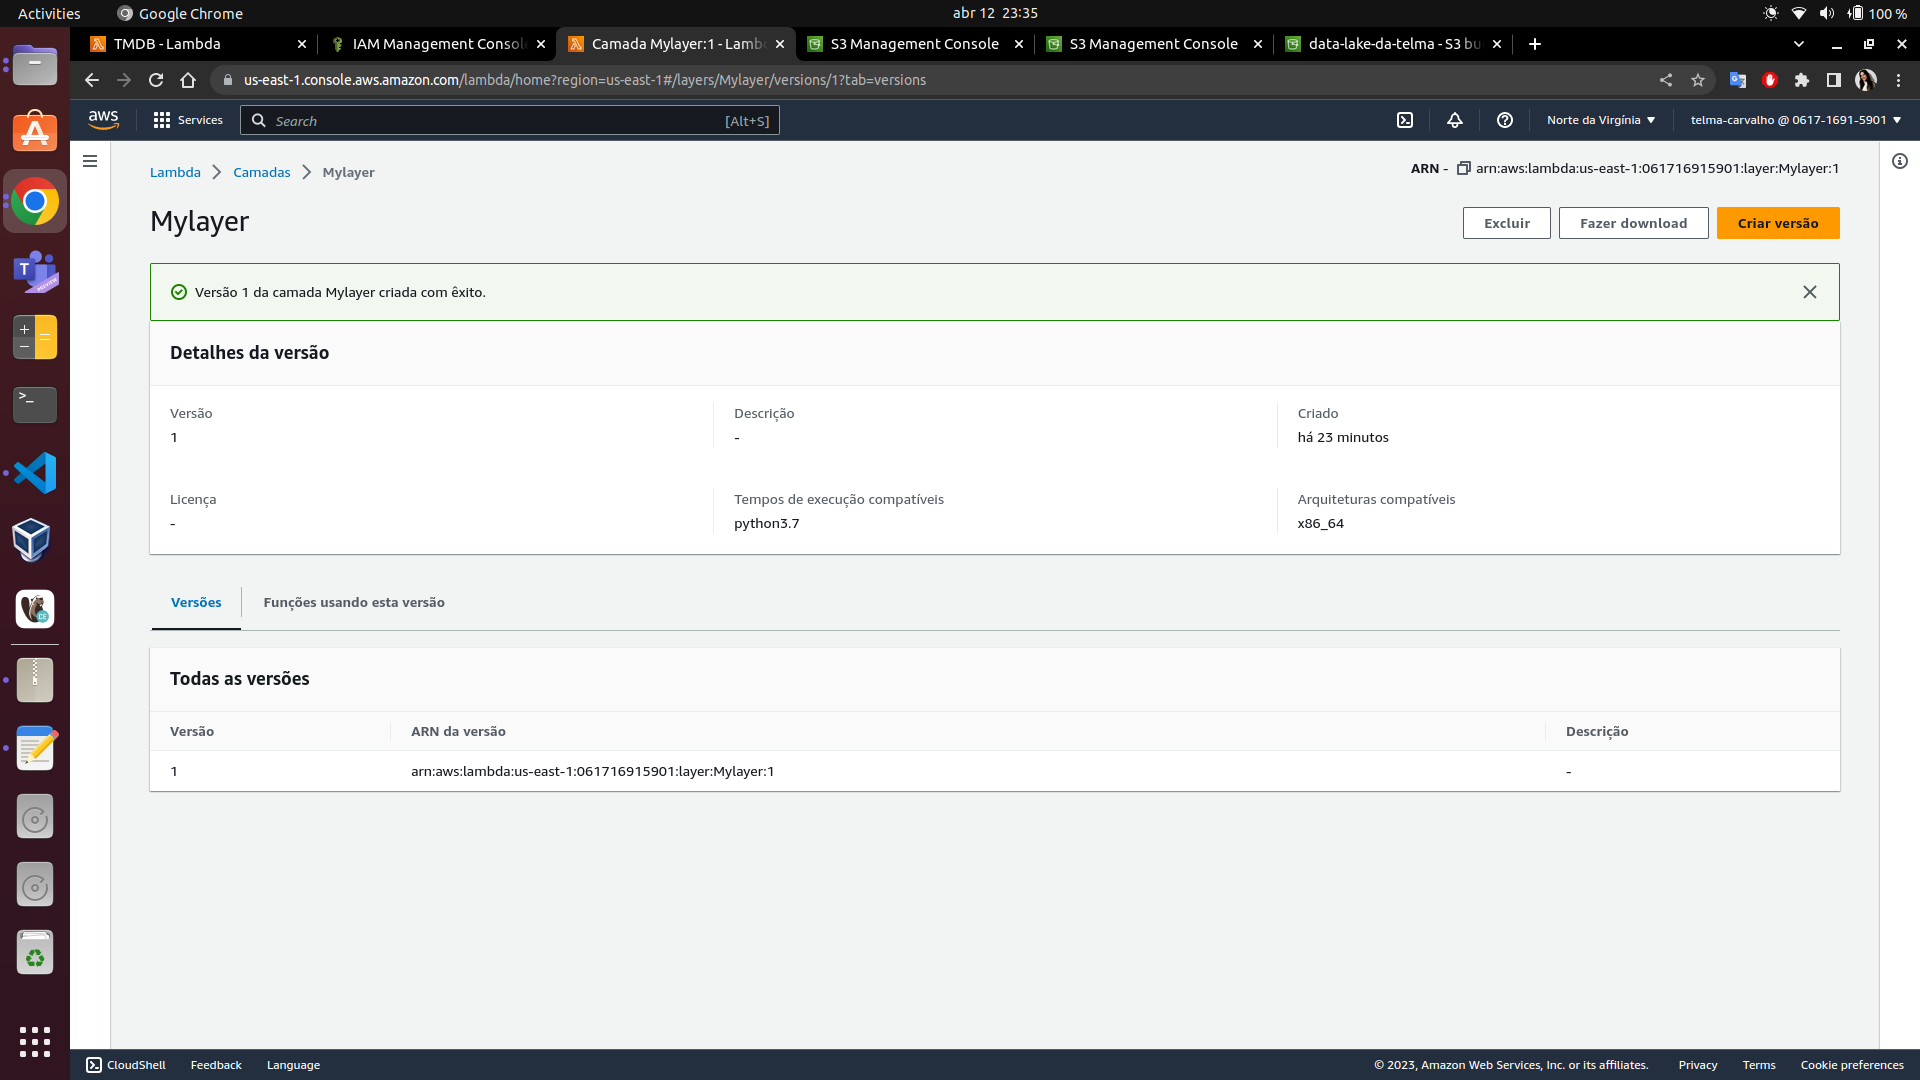

In [9]:
from IPython.display import Image
Image("Prints/Print5.png")

## Etapa 2

Implementar o código Python em AWS Lambda para consumo de dados do Twitter/TMDB:

   - Se está utilizando Twitter, buscar os tweets de interesse para a análise (neste ponto você já deve ter definido qual análise planeja realizar com os dados) e agrupar os tweets em arquivo JSON com, no máximo, 100 registros cada

   - Se está utilizando TMDB,  buscar pela API os dados que complementem a análise

   - Utilizar a lib boto3 para gravar os dados no AWS S3

    | no momento da gravação dos dados deve-se considerar o padrão de path: <nome do bucket>\<camada de armazenamento>\<origem do dado>\<formato do dado>\<especificação do dado>\<data de processamento separada por ano\mes\dia>\<arquivo>

              São exemplos de caminhos de arquivos válidos:

               - S3:\\data-lake-do-fulano\Raw\Twitter\JSON\2022\05\02\prt-uty-nfd.json

               - S3:\\data-lake-do-fulano\Raw\Twitter\JSON\2022\05\02\idf-uet-wqt.json



## Etapa 3

Caso esteja utilizando o Twitter, execute a função Lambda periodicamente para alimentar seu conjunto de dados no S3.

Informação adicional:

Podemos utilizar os serviços  **CloudWatch Event** ou **Amazon EventBridge** para agendar extrações periódicas de dados no Twitter de forma automática.

## Código

In [19]:
import requests
import pandas as pd
# from IPython.display import display
import boto3
from datetime import date
import os


def rawPath(file):
    names = file.split('.')
    today = date.today()
    date_path = today.strftime("%Y/%m/%d")
    path = 'Raw/TMDB/' + names[1].upper() + '/' + \
        names[0].capitalize() + '/' + date_path + '/' + file

    return path


def TMDBfeed(keywords, pages, data_specification):
    
    value = os.getenv('api_key')
    count_page = 1
    filmes = []
    while count_page <= pages:
        url = f"https://api.themoviedb.org/3/discover/movie?api_key={value}&page={count_page}&with_keywords={keywords}&sort_by=popularity.desc"

        response = requests.get(url)
        data = response.json()

        for movie in data['results']:
            df = {'Titulo': movie['title'],
                'Data de lançamento': movie['release_date'],
                'Visão geral': movie['overview'],
                'Votos': movie['vote_count'],
                'Média de votos:': movie['vote_average']}
            
            filmes.append(df)

        count_page += 1
           
    df = pd.DataFrame(filmes)
   
    df.to_json(f'/tmp/{data_specification}.json')

    # display(df)

def upload(file, bucket, data_specification):
    s3 = boto3.client('s3')
    s3.upload_file(f'/tmp/{data_specification}.json', bucket, rawPath(file))
     

def lambda_handler(event, context):
    pages = 3
    keywords = '9715'
    data_specification = 'superhero'
    
    TMDBfeed(keywords, pages, data_specification)
    upload(f'{data_specification}.json', 'data-lake-da-telma', data_specification) 
 

    return {
        'statusCode': 200,
        'body': f"ok"
    }

,Titulo,Data de lançamento,Visão geral,Votos,Média de votos:
0,Shazam! Fury of the Gods,2023-03-15,"Billy Batson and his foster siblings, who tran...",723,7.0
1,Black Panther: Wakanda Forever,2022-11-09,"Queen Ramonda, Shuri, M’Baku, Okoye and the Do...",4498,7.3
2,Ant-Man and the Wasp: Quantumania,2023-02-15,Super-Hero partners Scott Lang and Hope van Dy...,1230,6.3
3,Black Adam,2022-10-19,"Nearly 5,000 years after he was bestowed with ...",4668,7.1
4,Batman: The Doom That Came to Gotham,2023-03-10,Explorer Bruce Wayne accidentally unleashes an...,60,6.5
5,Legion of Super-Heroes,2023-02-07,"Kara, devastated by the loss of Krypton, strug...",78,6.3
6,Shazam!,2019-03-29,A boy is given the ability to become an adult ...,8429,7.0
7,Thor: Love and Thunder,2022-07-06,After his retirement is interrupted by Gorr th...,5738,6.6
8,Spider-Man: No Way Home,2021-12-15,Peter Parker is unmasked and no longer able to...,17153,8.0
9,Doctor Strange in the Multiverse of Madness,2022-05-04,"Doctor Strange, with the help of mystical alli...",7249,7.4


{'statusCode': 200, 'body': 'ok'}

## Prints de execução

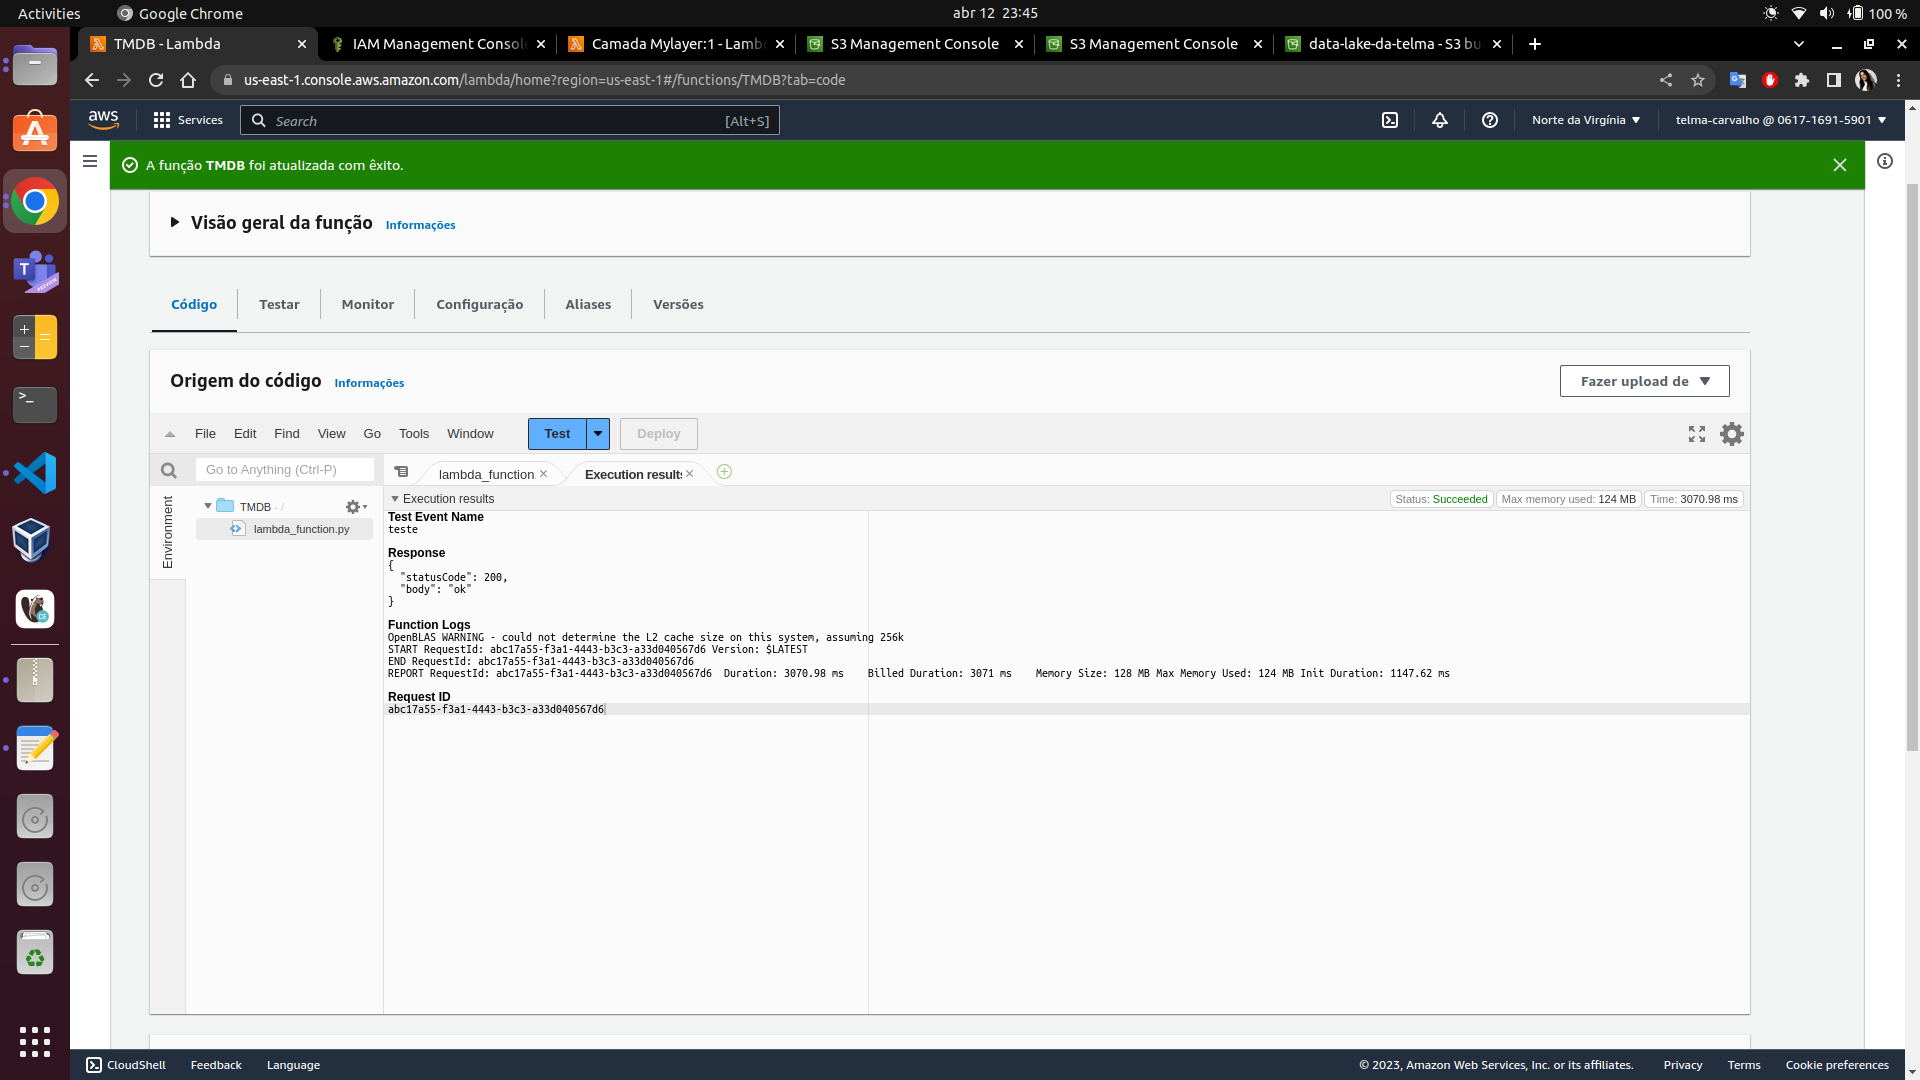

In [10]:
from IPython.display import Image
Image("Prints/Print6.png")

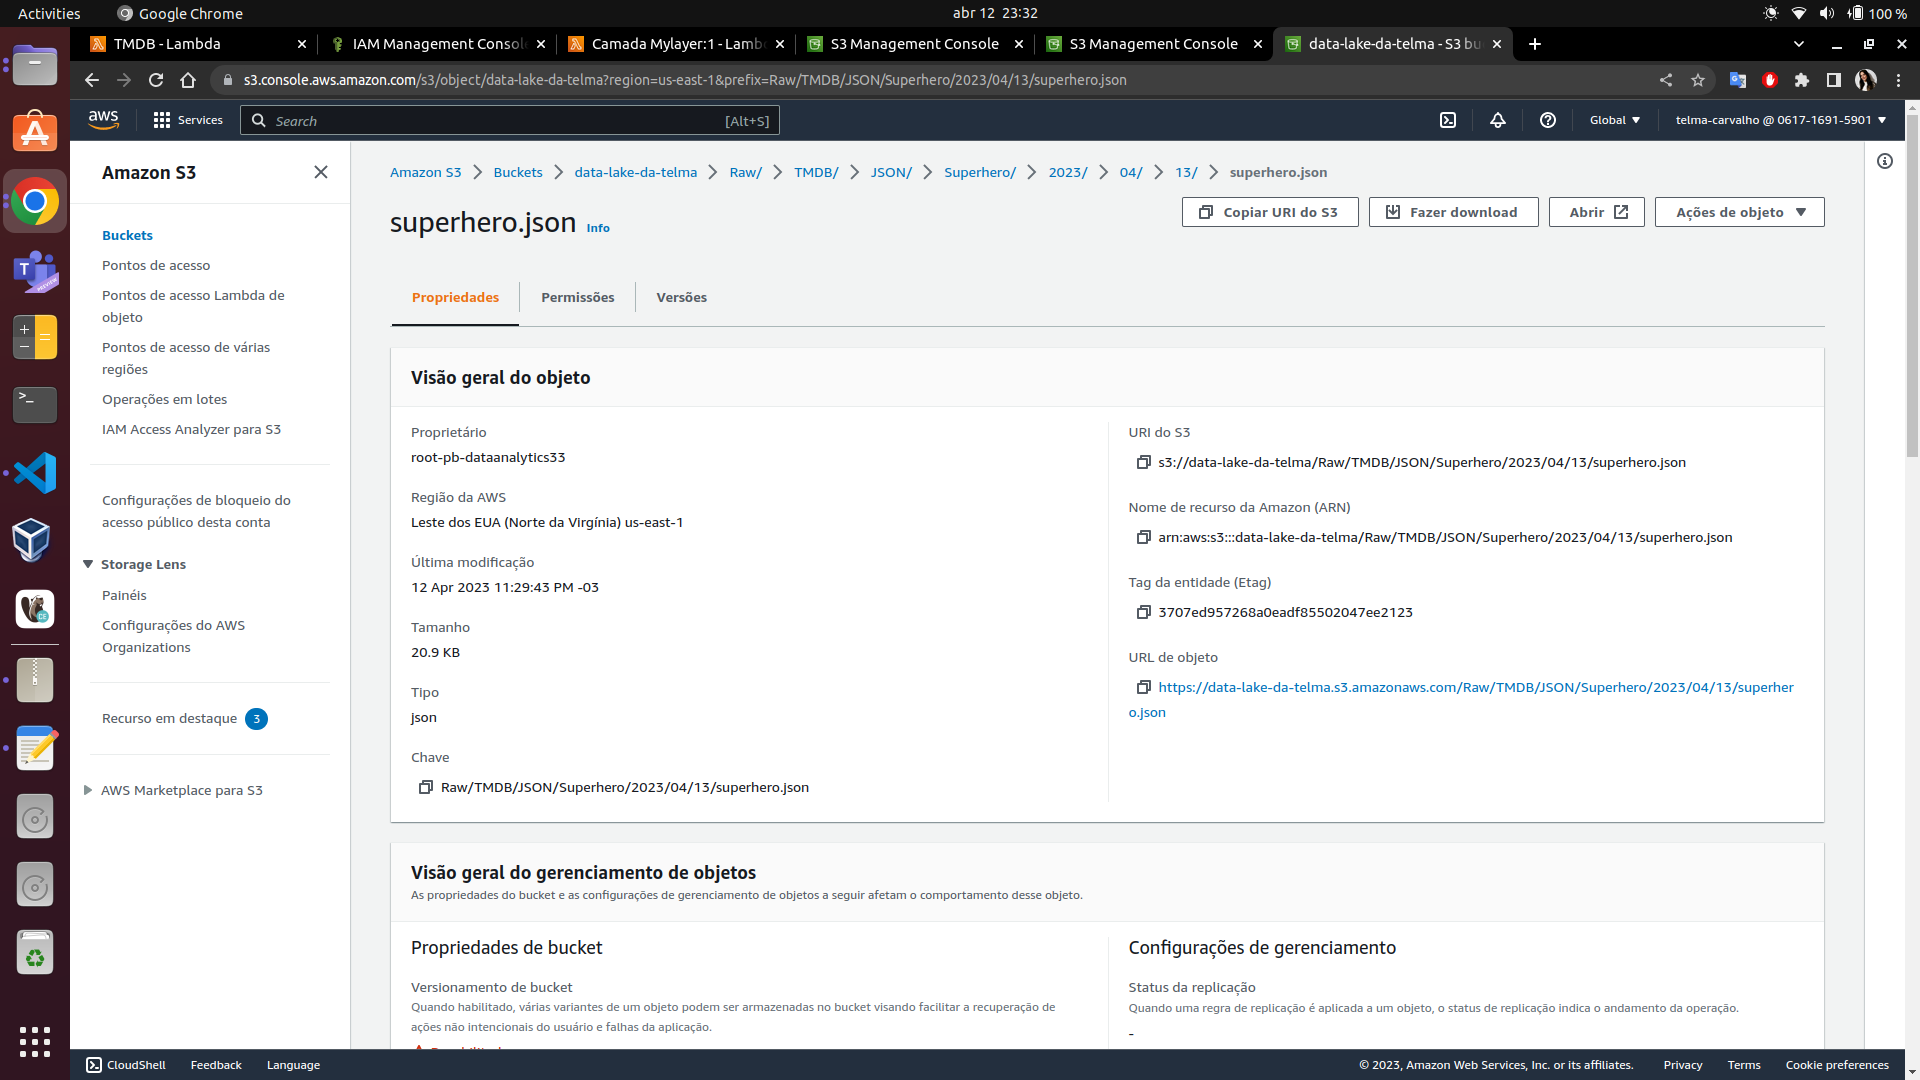

In [11]:
from IPython.display import Image
Image("Prints/Print7.png")